In [2]:
#Import

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import time 
from scipy.sparse import lil_matrix, kron,identity
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from scipy.sparse.linalg import lsqr
from sklearn import svm, datasets

In [3]:
#Data import (Point 3)

#Build structure containing the data we want to analyse
d = {'srcIP': ["16.85.22.12","16.85.22.12","16.85.22.13","16.85.22.12","16.85.22.14"],
     'dstIP': ["16.85.22.33","16.85.22.44","16.85.22.33","16.85.22.35"," 16.85.22.44"],
     'protocol': ["17","17","6","6","17"],'sPort': ["443","167","443","138","80"],
     'dPort': ["80","80","443","138","80"]}
#Build dataset from the defined structure
dfClassified = pd.DataFrame(data=d)
dfClassified

,srcIP,dstIP,protocol,sPort,dPort
0,16.85.22.12,16.85.22.33,17,443,80
1,16.85.22.12,16.85.22.44,17,167,80
2,16.85.22.13,16.85.22.33,6,443,443
3,16.85.22.12,16.85.22.35,6,138,138
4,16.85.22.14,16.85.22.44,17,80,80


In [4]:
#Define graphlet edges in a array
def graphletEdges(df):
    E=[]
    for index, row in df.iterrows():
        E.append((row["srcIP"], row["protocol"]+" "))
        E.append((row["protocol"]+" ", " "+row["dstIP"]))
        E.append((" "+row["dstIP"], " "+row["sPort"]+" "))
        E.append((" "+row["sPort"]+" ", "  "+row["dPort"]+"  "))
        E.append(("  "+row["dPort"]+"  ", "  "+row["dstIP"]))  
    return E

In [5]:
# Create a single graphlet indicating the srcIP of the graphlet
def computeGraphlet(src,df):
    G = nx.DiGraph()
    G.add_edges_from(graphletEdges(df[df.srcIP==src])) # Taking advantage of the previously defined function
    return G

In [6]:
# Plot of a single graphlet giving in input the srcIP of the specific graphlet and the dataset
def plotGraflet(src,df):
    G=computeGraphlet(src,df) # Building graphlet of the srcIP
    pos = graphviz_layout(G, prog='dot') # Perfect plot layout for graph visualization 
    nx.draw(G,pos,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9) # Graph plot
    #nx.draw_networkx_edges(G, pos, edgelist=anomalE,width=8, alpha=0.4, edge_color='r') # Anomal edges plot
    plt.show()

In [7]:
# Plot of every graphlet contained in a given data set
def plotMultipleGraflet(df):
    for i in range(len(df.srcIP.unique())):
        fig= plt.figure(figsize=(7, 7)) # Create a new figure for the every single graphlet 
        plotGraflet(df.srcIP.unique()[i],df) # Plot the graphlet with specific srcIP

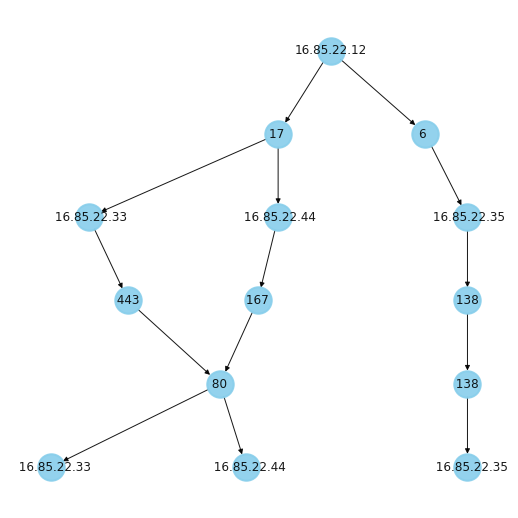

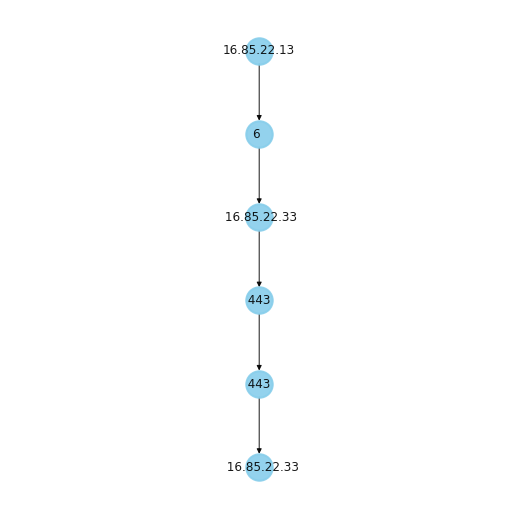

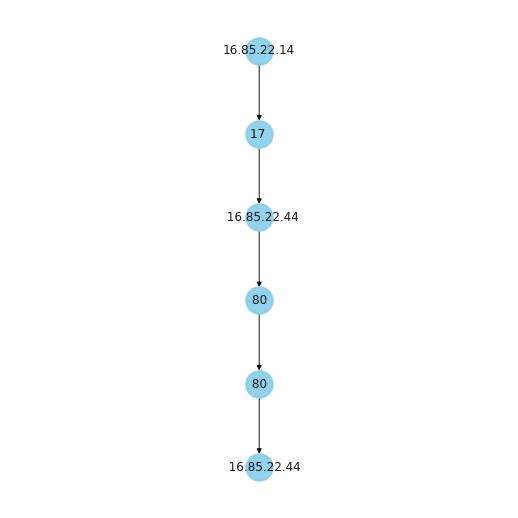

In [8]:
# Creation of sub-set of the complete dataset containing the flow of just specific sources
def dfFromSources(srcArray,df):
    dfArray=[]
    for i in srcArray:
        dfArray.append(df[df.srcIP==i])
    return pd.concat(dfArray)

# Visualization of simple graphlet
plotMultipleGraflet(dfClassified)

In [9]:
#(Punto 4) Dataset import and model building
dfClassified = pd.read_csv('C:/Users/alexm/Desktop/Data Mining/Project/annotated-trace.csv').astype(str) # Upload dataset from file 
dfClassified
dfClassified.columns=['srcIP','dstIP','protocol','sPort','dPort','label']
dfClassified

,srcIP,dstIP,protocol,sPort,dPort,label
0,395,594,17,25,443,normal
1,849,227,6,20,22,normal
2,333,954,6,53,23,normal
3,450,52,6,53,25,normal
4,516,517,1,80,79,normal
...,...,...,...,...,...,...
10064,506,759,6,53,68,normal
10065,719,481,17,53,68,normal
10066,945,994,6,20,80,normal
10067,556,28,89,25,80,normal


In [10]:
# Building the array of graphlets from a dataset (punto 5)

def allGraphlets(df):
    graphlets = []
    srcIP = list(df.srcIP.unique())
    for i in range(len(srcIP)):
        graphlets.append(computeGraphlet(srcIP[i],df))
    return graphlets

#Stampa tutti i graphlet del file csv
#plotMultipleGraflet(dfClassified)

In [11]:
# Check if a graphlet contains anomalies
def hasAnomalies(src,df):
    graph=df[df.srcIP==src]
    return len(graph[graph.label=="anomaly"]) != 0

hasAnomalies("395",dfClassified) # Test

False

In [12]:
# Function used for computing the feature vector, it is based on the adjacency matrix of a graphlet and walk lenght
def computeFeatureVector(walkLength,graphlet):
    # Create the adjacency matrix of a graphlet 
    a=nx.adjacency_matrix(graphlet,nodelist=sorted(graphlet.nodes())).todense() 
    i=np.identity(a.shape[0], dtype = int ) # Identity matrix of the same size of the adjacency matrix
    b=a # 1 walk adjacency matrix
    res=i+a
    for i in range(1,walkLength):
        a=np.dot(a,b) # Dot product of A^i and A
        res+=a
    return np.squeeze(np.asarray(res)).flatten() # Flat of the adjacency matrix

[11 10 10 10 11 10 10 10 11]


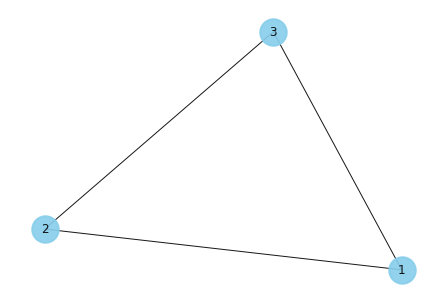

In [13]:
# Execution of the above example
G = nx.Graph()
G.add_edges_from([(1,2),(2,3),(3,1)])
nx.draw(G,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
print(computeFeatureVector(4,G))

In [14]:
# Transform all the graphlet into high dimensional space of the random walk kernel with length 4 (Punto 6)
def allFeatures(df,pad):
    Y=[]
    graphlets = allGraphlets(df)
    features = [] # Feature vector
    maxlen=0 # Biggest feature vector length
    srcIP = list(df.srcIP.unique()) # List of all srcIP in the dataset
    for i in range(len(srcIP)): # Compute feature vector for every graphlet
        features.append(computeFeatureVector(4,graphlets[i]))
        if (len(features[i]) > maxlen): # Save the biggest feature vector length
                maxlen=len(features[i]) 
        if (hasAnomalies(srcIP[i],df)): # Check if a graphlet contain anomalies for labeling it
            Y.append("anomaly")
        else:
            Y.append("normal")
    # Padding with specific value all the feature vector
    for i in range(len(srcIP)):
        features[i] = np.pad(features[i], (0,maxlen-features[i].size), 'constant', constant_values=(pad))
    return features, Y, maxlen

features, Y, maxlen= allFeatures(dfClassified,0)

Size of training set:  800
Size of testing set:  201
Computation time:  0.18999981880187988 s
0.9203980099502488
              precision    recall  f1-score   support

     anomaly       0.00      0.00      0.00        16
      normal       0.92      1.00      0.96       185

    accuracy                           0.92       201
   macro avg       0.46      0.50      0.48       201
weighted avg       0.85      0.92      0.88       201



C:\Users\alexm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

SVC(gamma='auto', kernel='linear')

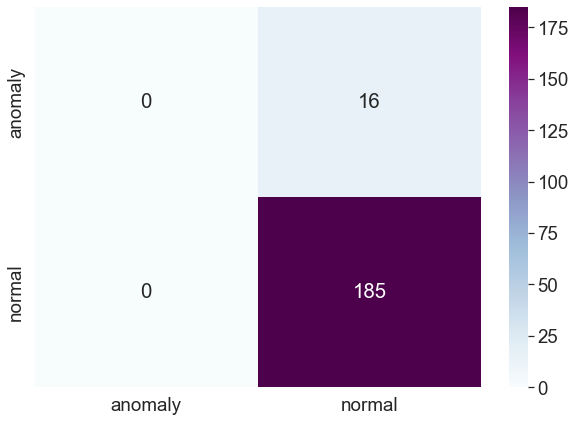

In [15]:
# Splitting feature vector and label vector in training and test   (Punto 7)
X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.2,random_state=0)
clf = svm.SVC(gamma='auto',kernel='poly')
clf.fit(X_train, y_train)
print ("Size of training set: ",len(X_train))
print("Size of testing set: ",len(X_test))
time_start = time.time()
y_pred= clf.predict(X_test) # Using test feature vector for check the accuracy
time_elapsed = (time.time() - time_start)
print ("Computation time: ", time_elapsed,"s")
print (accuracy_score(y_test,y_pred)) # Comparing the predicted label with the real ones
print (classification_report(y_test, y_pred)) # Printing the accuracy comparing the true labels with the predicted ones for each labe

# Creating the confusion matrix 
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.7)
sns.heatmap(df_cm, annot=True, fmt='g',cmap="BuPu",xticklabels=["anomaly","normal"], yticklabels=["anomaly","normal"] )
# Training the model without splitting in training and test
clf1 = svm.SVC(gamma='auto',kernel='linear')
clf1.fit(features, Y)

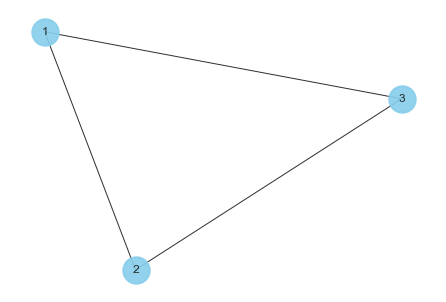

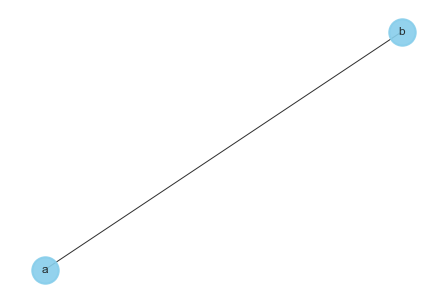

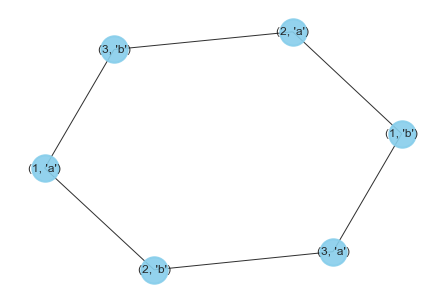

In [16]:
#Punto 8 (esempio)
# Reproducing the class example of the direct product graph
G1 = nx.Graph()
G1.add_edges_from([(1,2),(2,3),(1,3)])
G2 = nx.Graph()
G2.add_edges_from([('a','b')])
plt.figure(1)
nx.draw(G1,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
plt.figure(2)
nx.draw(G2,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
plt.figure(3)
G=nx.tensor_product(G1, G2) # Direct product graph
nx.draw(G,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)

In [24]:
# Creating the random kernel trick that take as input two graphs
def randomWalkKernelTrick(G, H):
    LAMBDA = 0.1
    productGraph = nx.tensor_product(G,H) # Tensor product of graphlet 
    a=nx.adjacency_matrix(productGraph,nodelist=sorted(productGraph.nodes())).todense()
    print (a)
    i=np.identity(a.shape[0], dtype = int )
    res=np.linalg.inv(i-LAMBDA*a).sum() # Calculating kernel value
    return res

#Testing the kernel trick function with the previous two graphs G1 and G2
time_start = time.time()
res=randomWalkKernelTrick(G1, G2)
time_elapsed = (time.time() - time_start)
print ("Kernel value: ",res)
print ("Computation time: ", time_elapsed,"s")

[[0 0 0 1 0 1]
 [0 0 1 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 0 0]
 [1 0 1 0 0 0]]
Kernel value:  7.500000000000002
Computation time:  0.0010013580322265625 s


In [25]:
# Creating the random kernel trick that take as input two adjacency matrices
def randomWalkKernelTrick(Ax, Ay):
    Az = np.kron(Ax,Ay) # Kronecker product of the adjacency matrices
    LAMBDA = 0.1
    print (Az)
    i=np.identity(Az.shape[0], dtype = int )
    res=np.linalg.inv(i-LAMBDA*Az).sum() # Calculating kernel value
    return res

# Execution
Ax=nx.adjacency_matrix(G1).todense()
Ay=nx.adjacency_matrix(G2).todense()
time_start = time.time()
res=randomWalkKernelTrick(Ax, Ay)
time_elapsed = (time.time() - time_start)
print ("Kernel value: ",res)
print ("Computation time: ", time_elapsed,"s")

[[0 0 0 1 0 1]
 [0 0 1 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 0 0]
 [1 0 1 0 0 0]]
Kernel value:  7.500000000000002
Computation time:  0.003009796142578125 s


In [26]:
def randomWalkKernelTrick(Ax, Ay):
    res = []
    for i in range(len(Ax)):
        temp=[]
        A1 = Ax[i][Ax[i] != -1] # Remove padding
        A1 = A1.reshape(int(math.sqrt(A1.size)),int(math.sqrt(A1.size))) # Resize into a matrix
        for j in range(len(Ay)):              
            A2 = Ay[j][Ay[j] != -1]  # Remove padding          
            A2 = A2.reshape(int(math.sqrt(A2.size)),int(math.sqrt(A2.size))) # Resize into a matrix
            Az = np.kron(A1,A2) # performing Kronecker product
            LAMBDA = 0.1
            i=np.identity(Az.shape[0], dtype = int )
            temp.append(np.linalg.inv(i-LAMBDA*Az).sum())
        res.append(temp)
        print ("Iteration:",len(res))
    return res

In [27]:
# Computation of the features
features, Y, maxlen=allFeatures(dfClassified,-1)
# Fit phase done with few entries because too much expensive for my working machine
subsetSize= 50  #setta in base alle esigenze
clf2 = svm.SVC(gamma='auto',kernel=randomWalkKernelTrick)
clf2.fit(features[:subsetSize], Y[:subsetSize])
time_start = time.time()
y_pred= clf2.predict(features[subsetSize:2*subsetSize])
time_elapsed = (time.time() - time_start)
print ("Computation time: ", time_elapsed,"s")

cm=confusion_matrix(Y[:subsetSize], y_pred,labels=['anomaly', 'normal'])
df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.7)
sns.heatmap(df_cm, annot=True, fmt='g',cmap="BuPu")

KeyboardInterrupt: 

Computation time:  1.1179709434509277 s


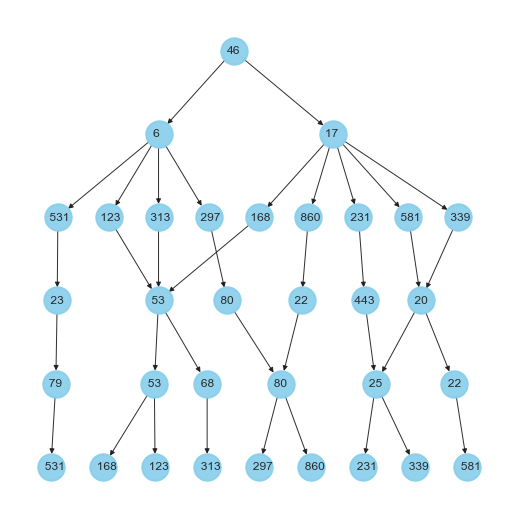

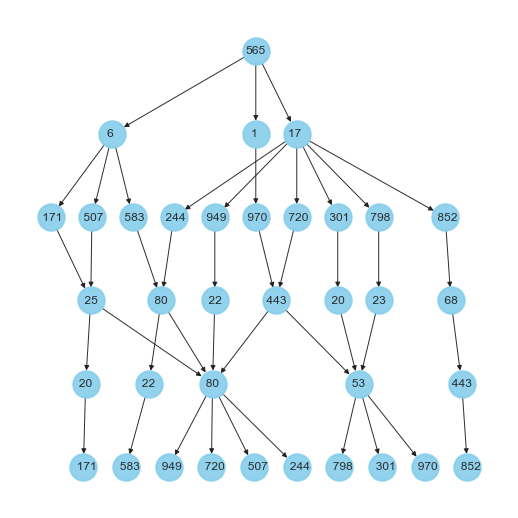

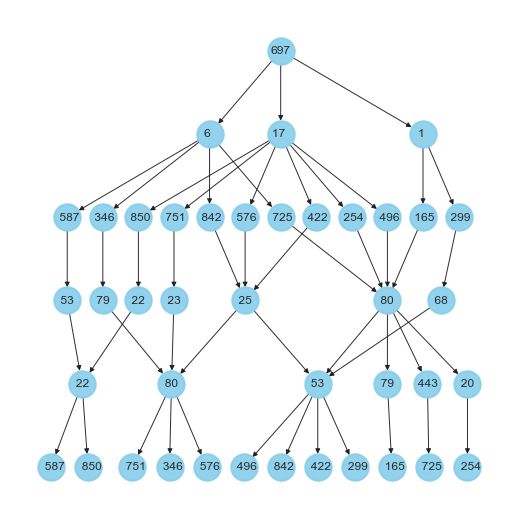

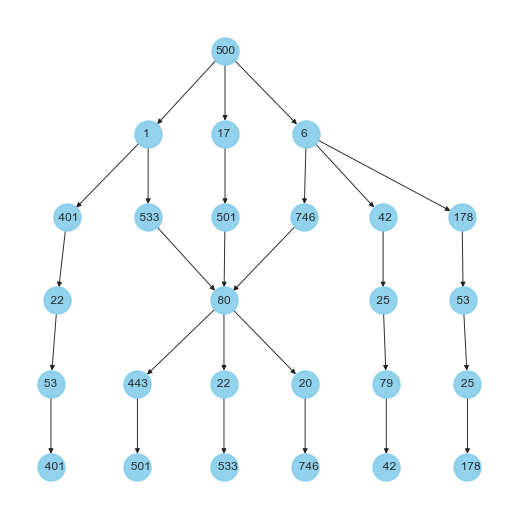

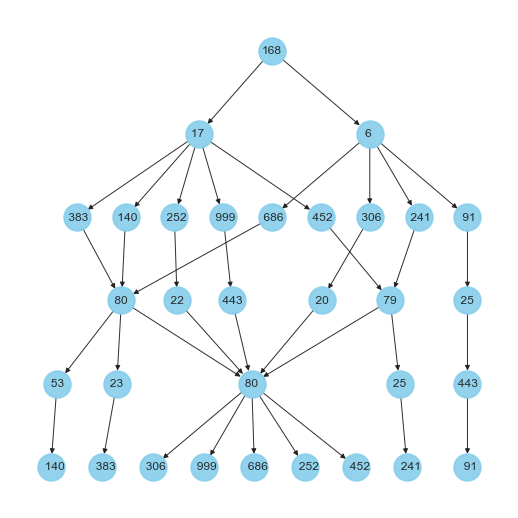

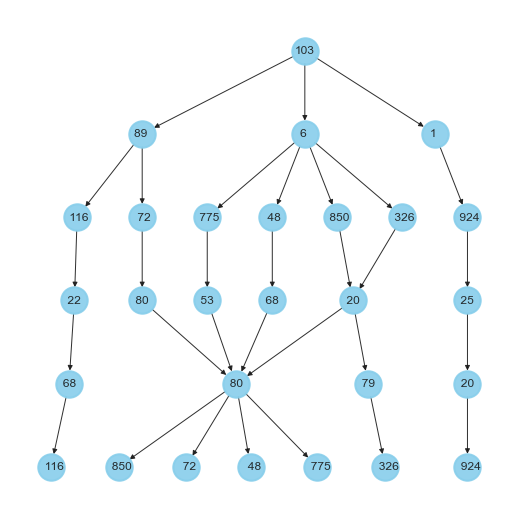

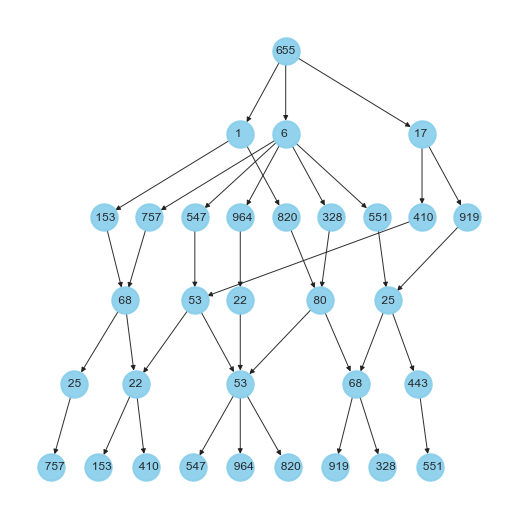

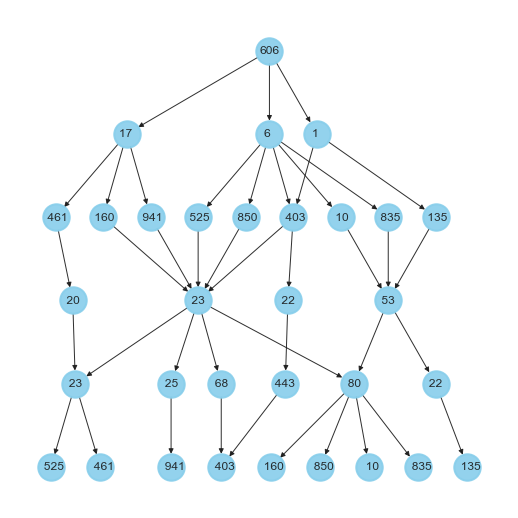

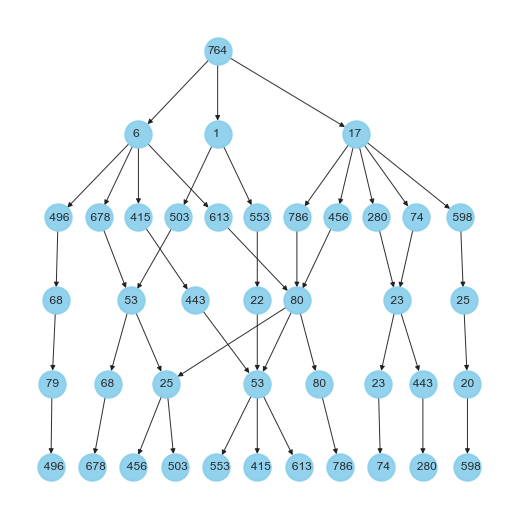

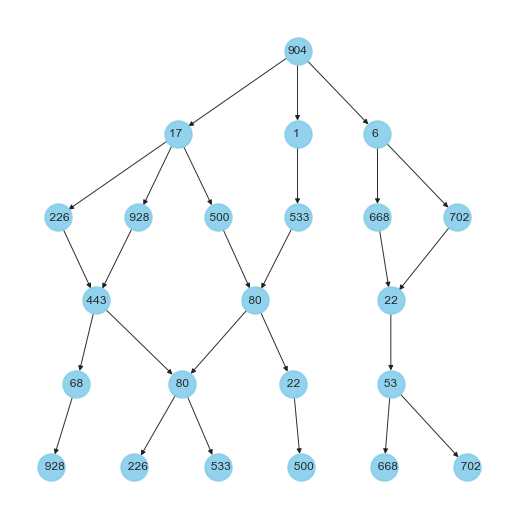

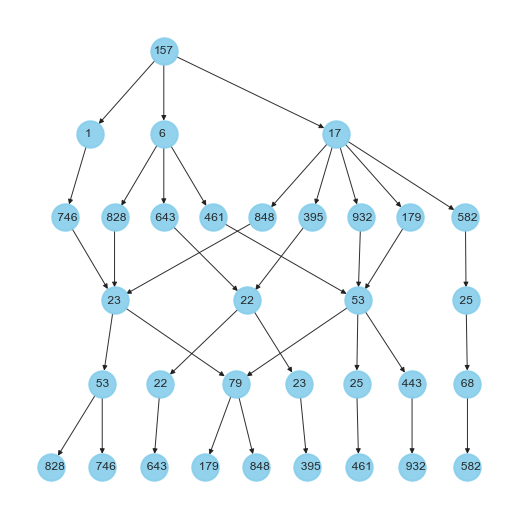

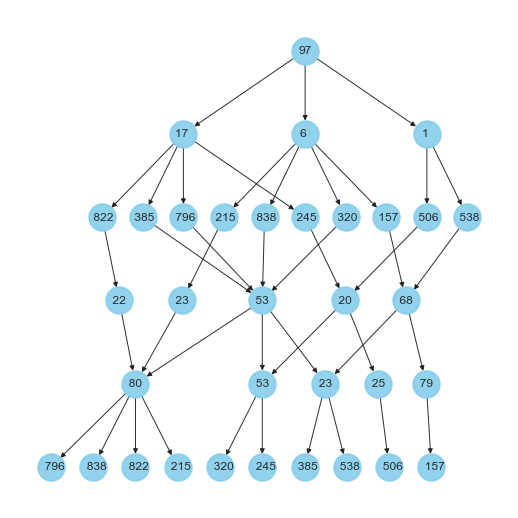

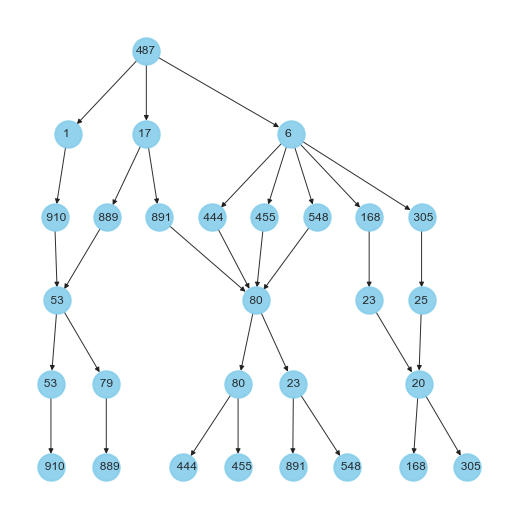

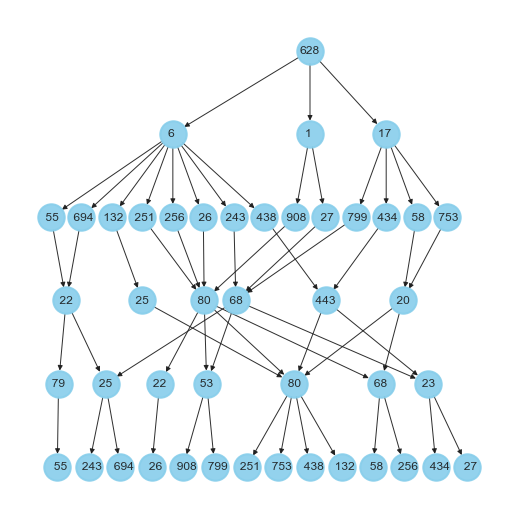

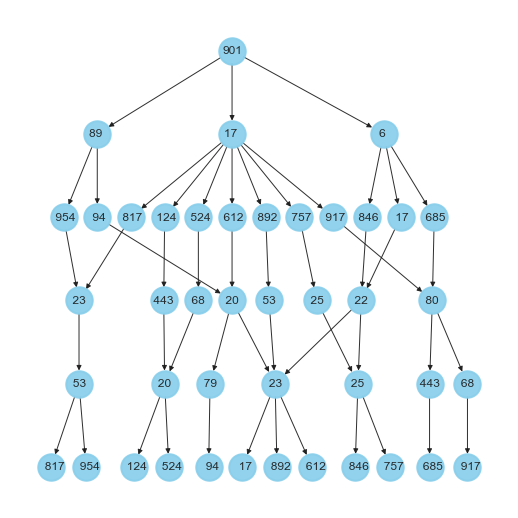

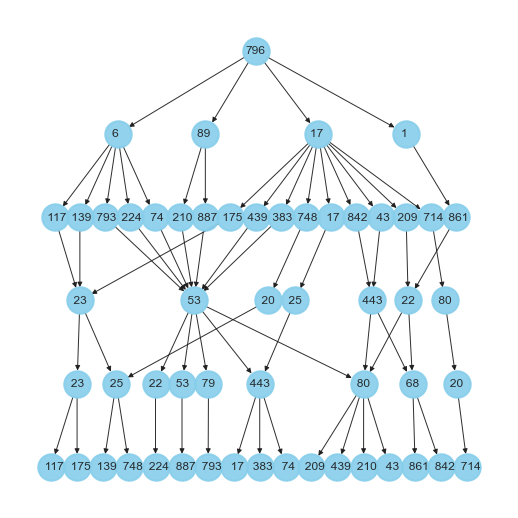

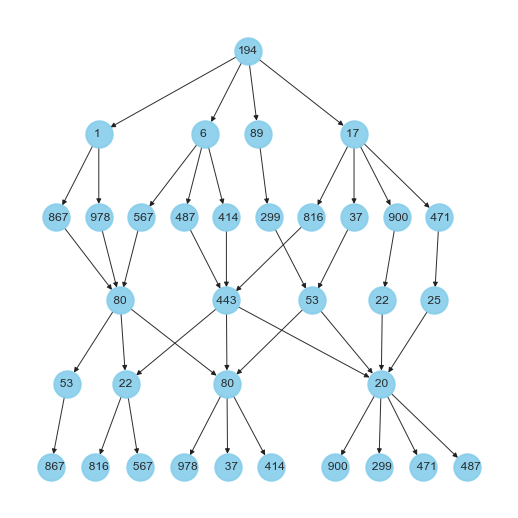

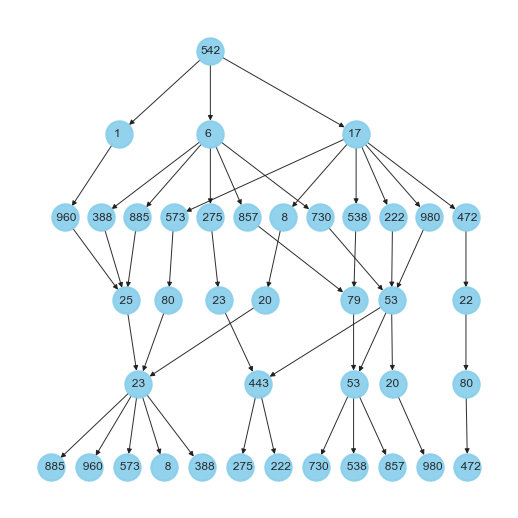

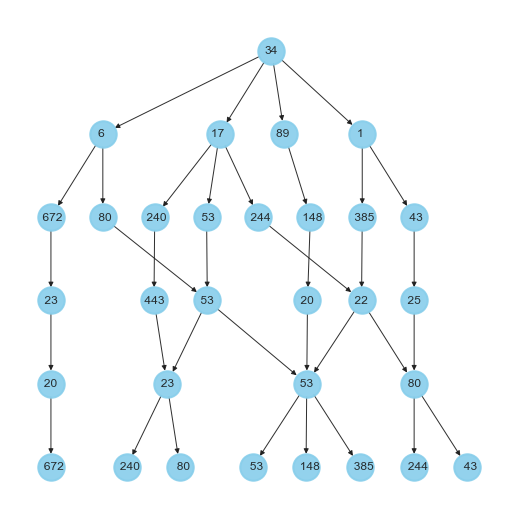

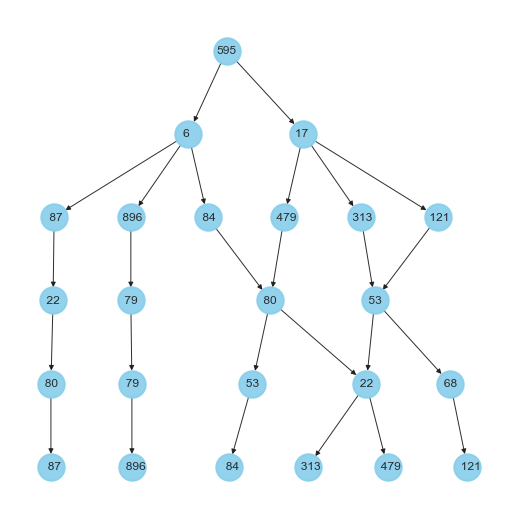

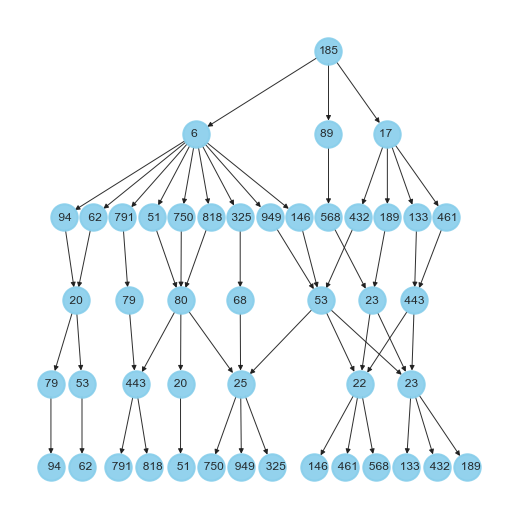

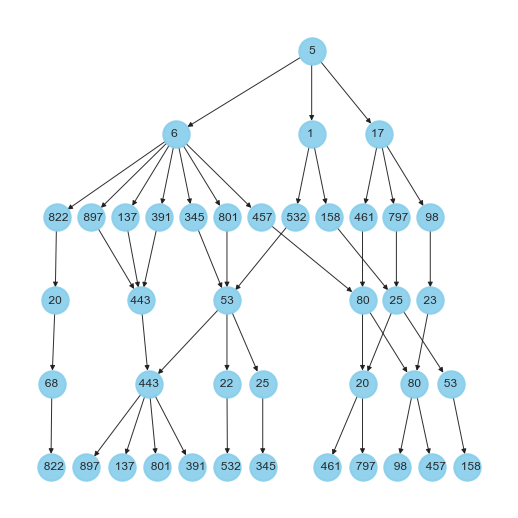

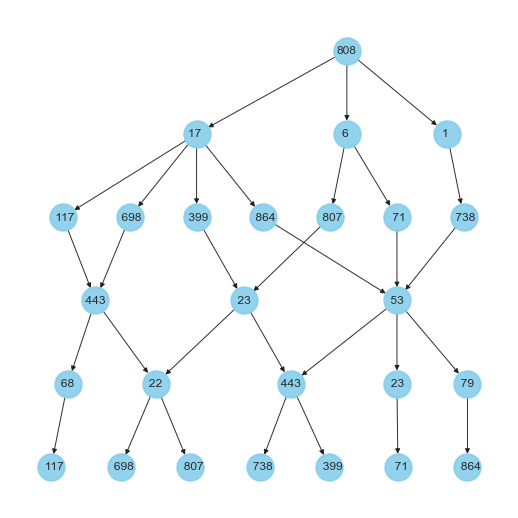

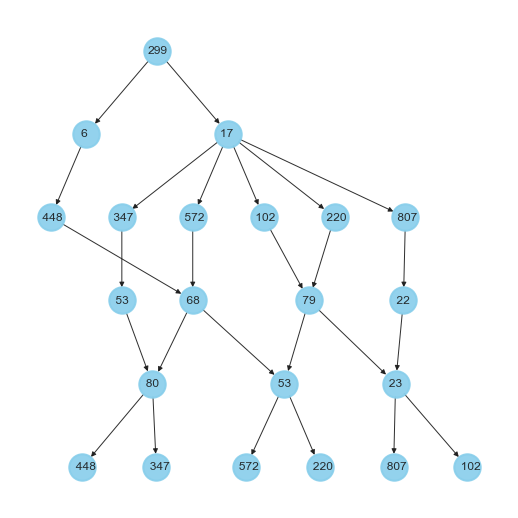

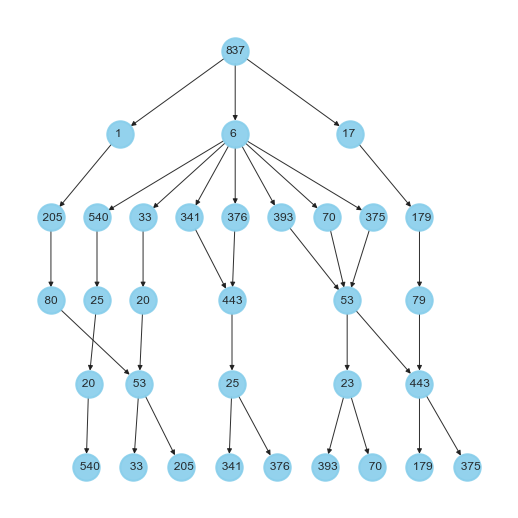

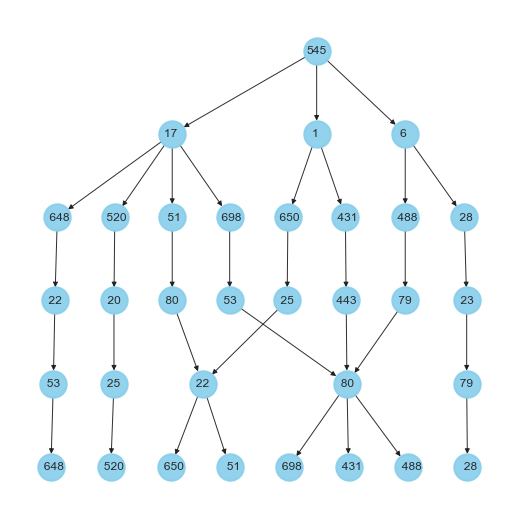

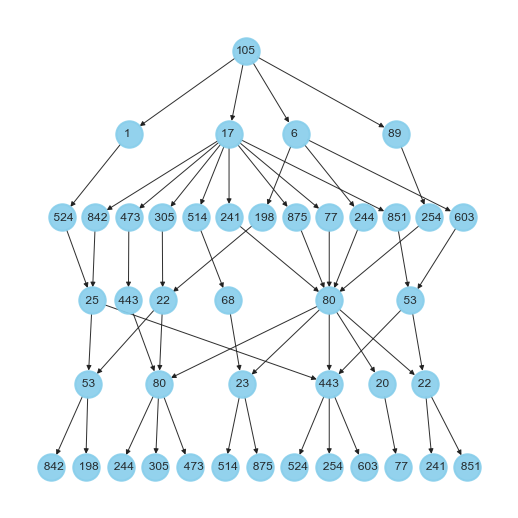

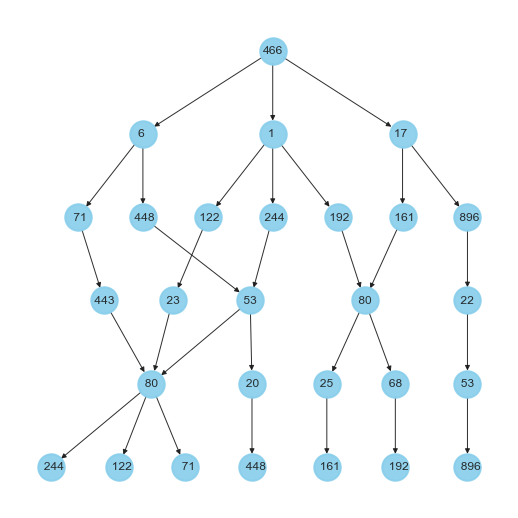

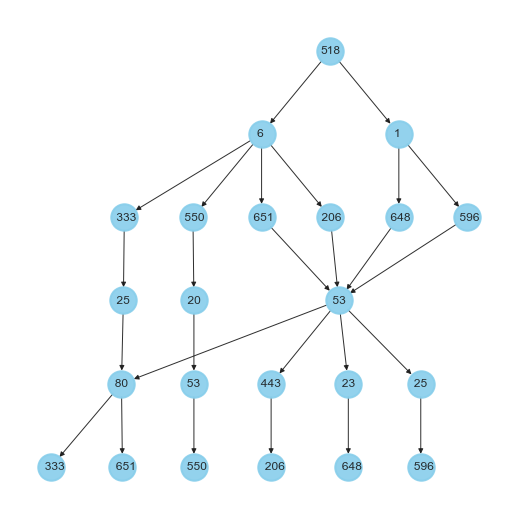

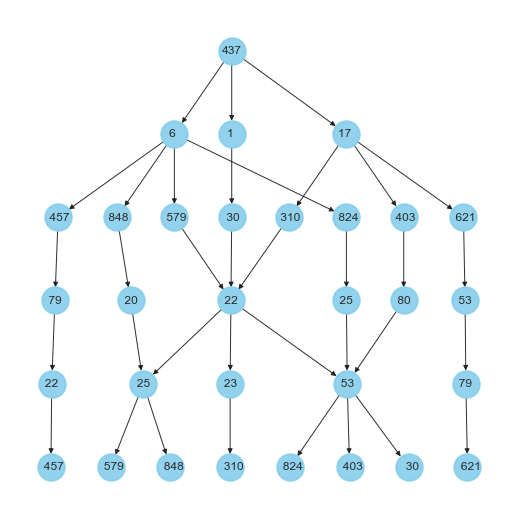

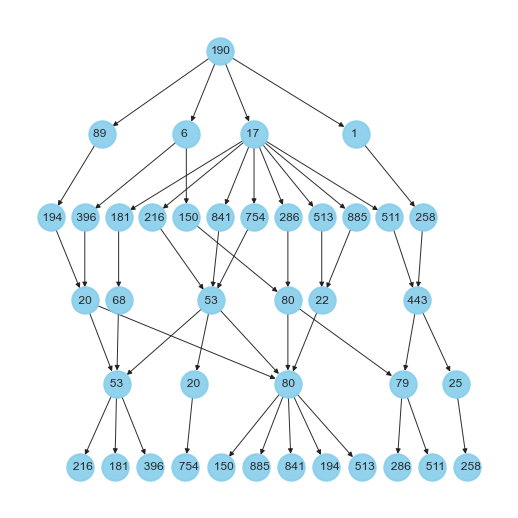

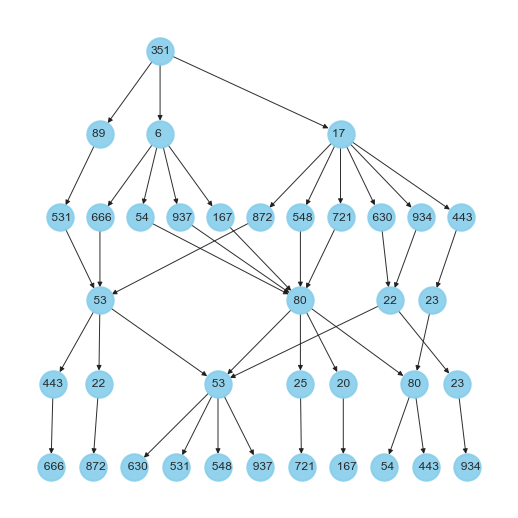

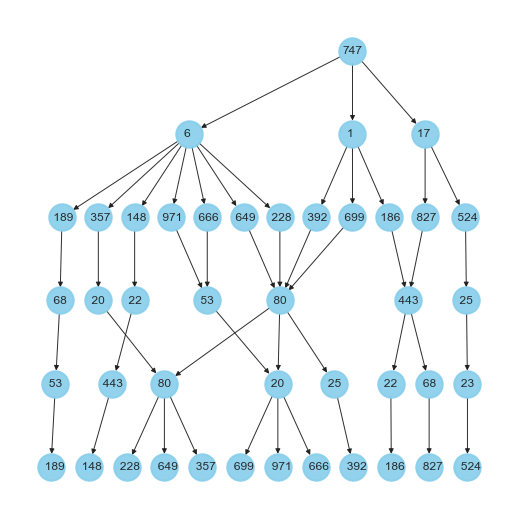

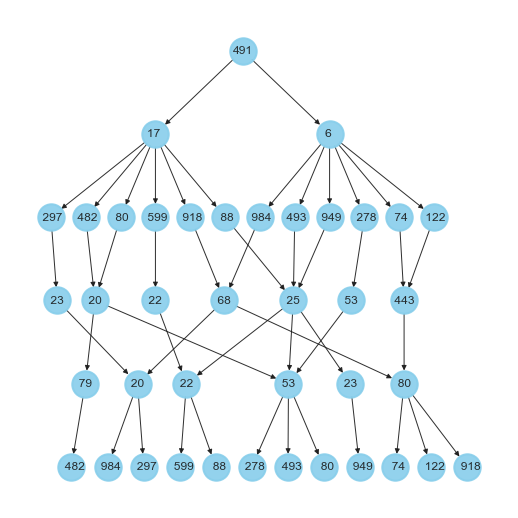

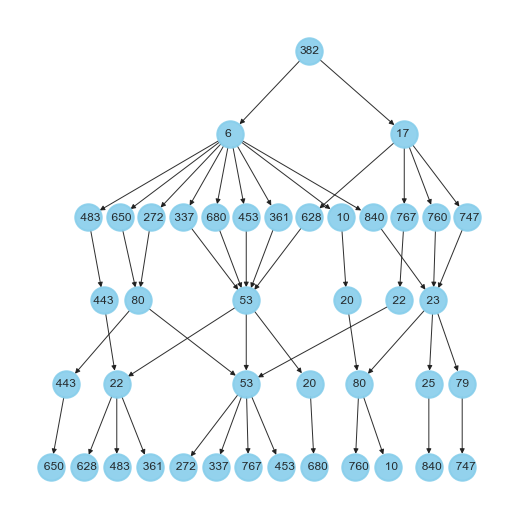

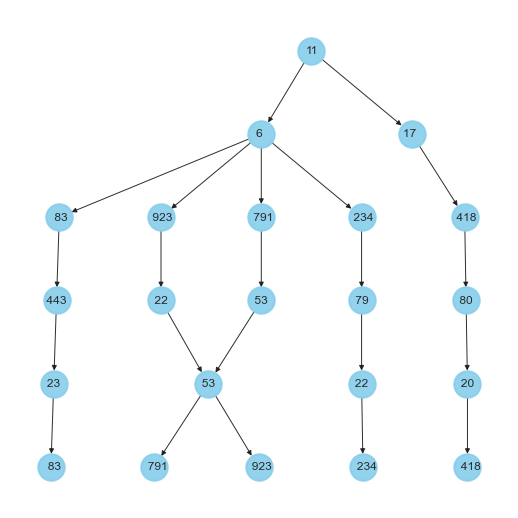

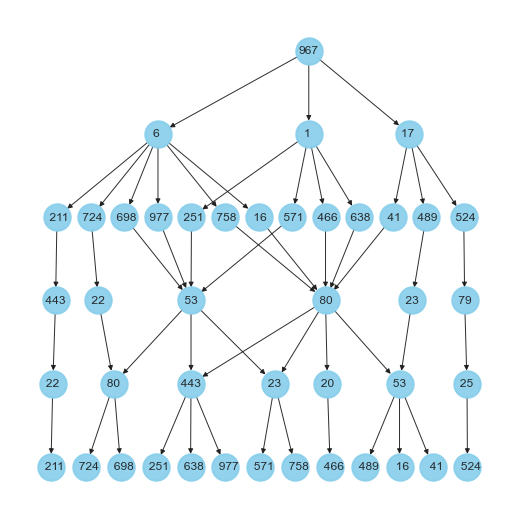

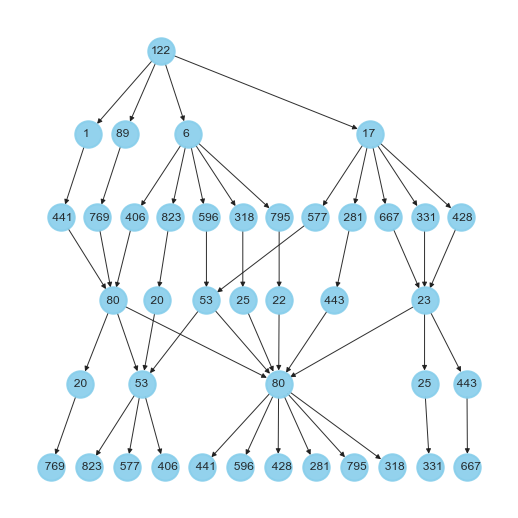

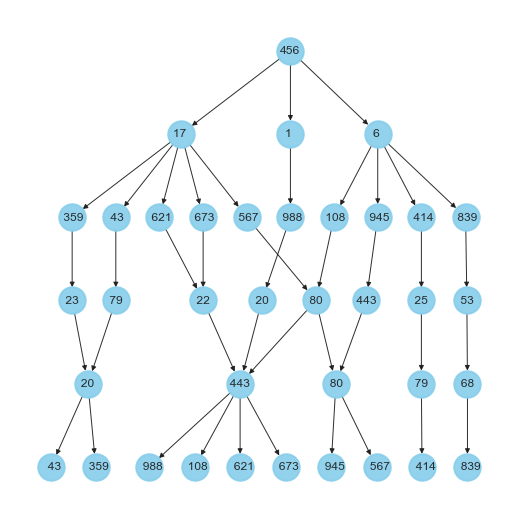

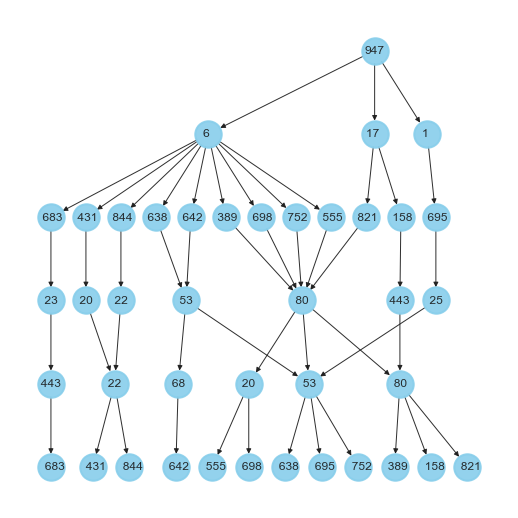

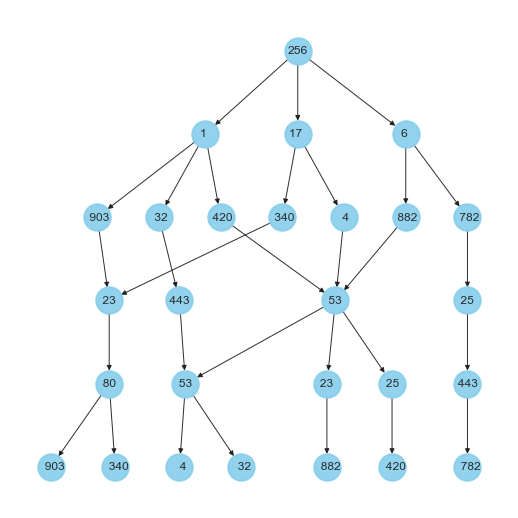

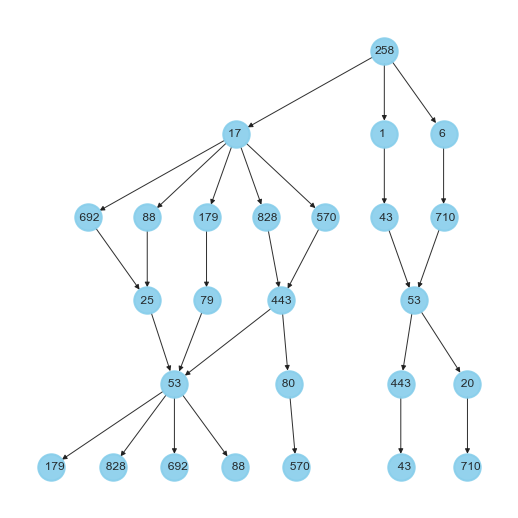

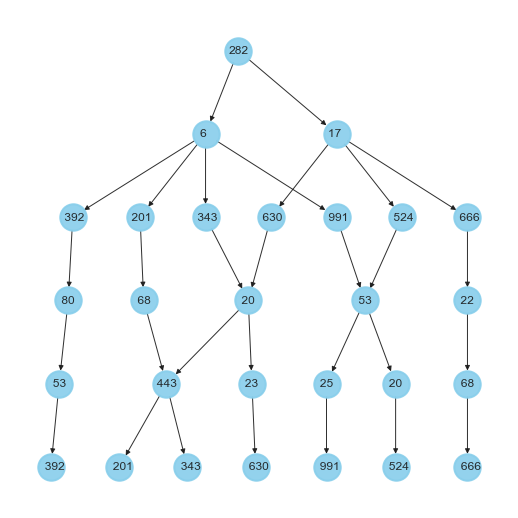

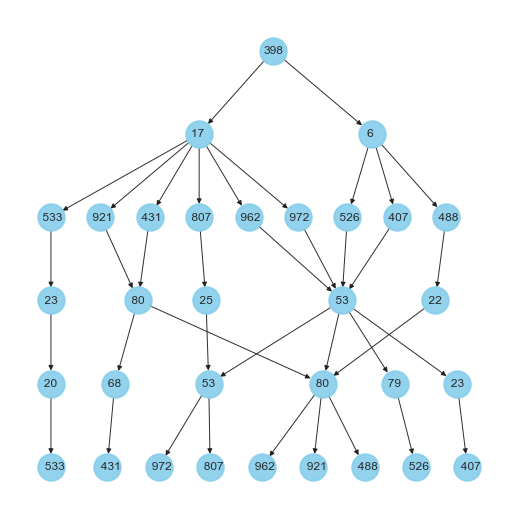

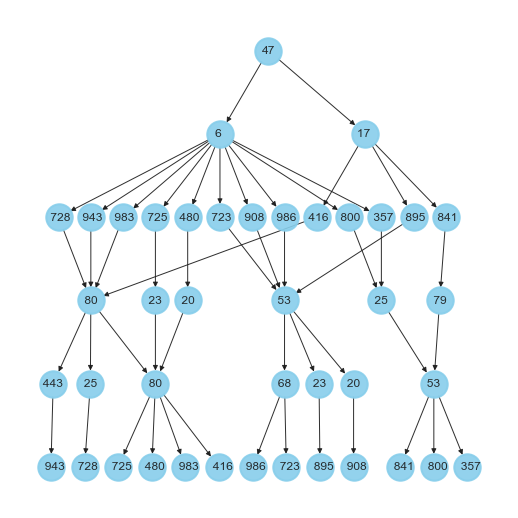

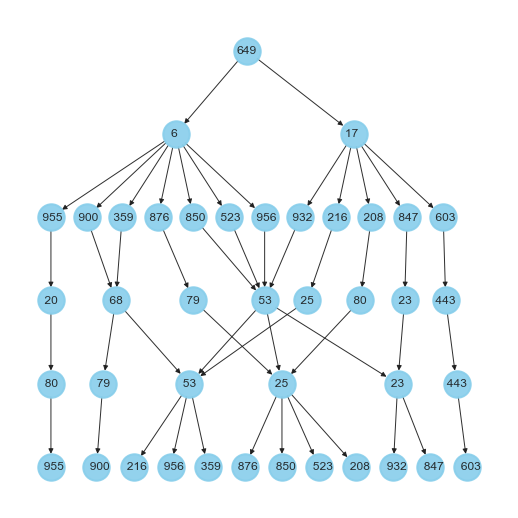

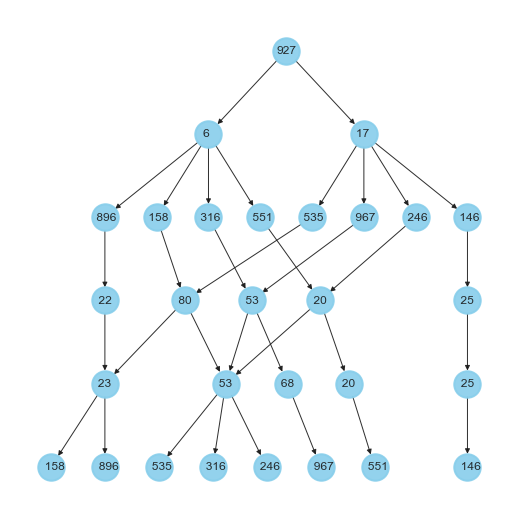

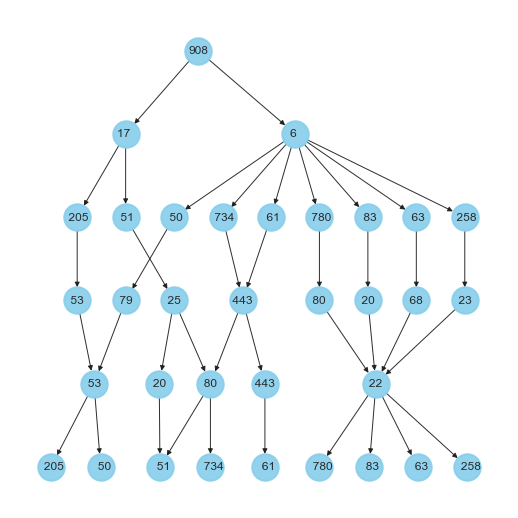

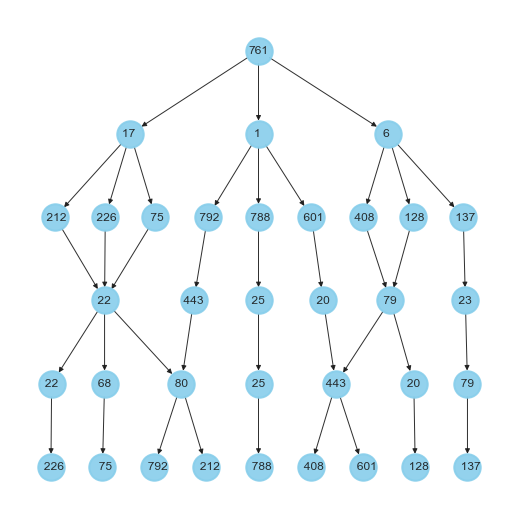

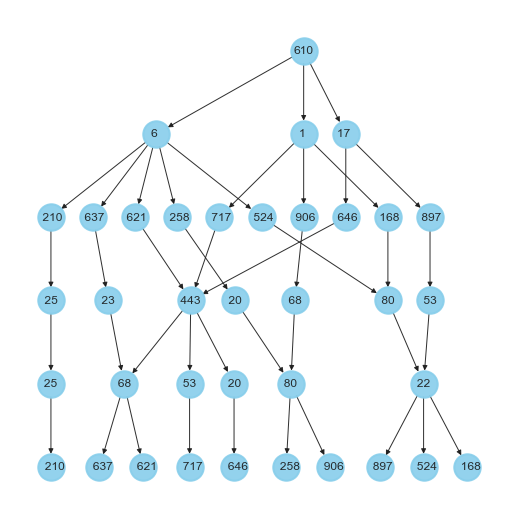

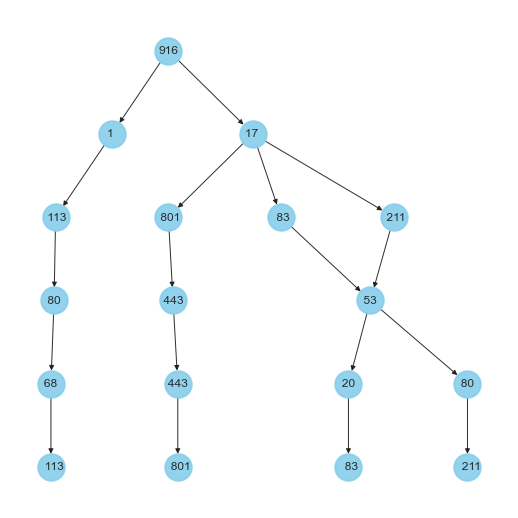

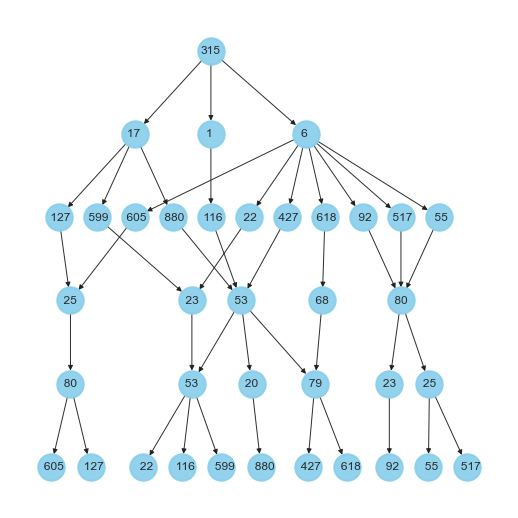

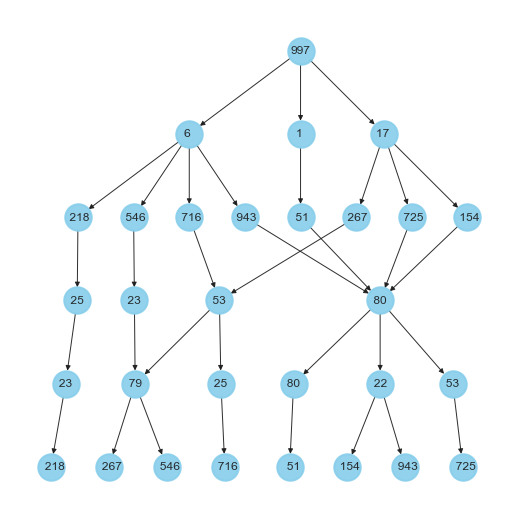

Iteration: 1
Iteration: 2
Iteration: 3
Computation time:  164.36671257019043 s


AttributeError: 'DataFrame' object has no attribute 'label'

In [ ]:
#Punto 9
featuresUnclassified = []
dfUnclassified = pd.read_csv('C:/Users/alexm/Desktop/Data Mining/Project/not-annotated-trace.csv').astype(str) # Load unclassified graph
dfUnclassified.columns=['srcIP','dstIP','protocol','sPort','dPort']
graphlets= allGraphlets(dfUnclassified) # Obtaining all the graphlet
srcIP = list(dfUnclassified.srcIP.unique())
for i in range(len(srcIP)):
    featuresUnclassified.append(computeFeatureVector(4,graphlets[i])) # Building feature vector
for i in range(len(srcIP)):
    featuresUnclassified[i]=np.squeeze(np.resize(featuresUnclassified[i],(1,maxlen))) # padding with zeros

# Predicting without kernel trick
time_start = time.time()
y_pred= clf1.predict(featuresUnclassified)
time_elapsed = (time.time() - time_start)
print ("Computation time: ", time_elapsed,"s")
predictions = pd.DataFrame({'srcIP':srcIP,'label':y_pred})
predictions[predictions.label=="anomaly"]
#Plot detected anomaly graphlet without kernel trick method
plotMultipleGraflet(dfFromSources(predictions[predictions.label=="anomaly"]["srcIP"],dfClassified))
# Predicting with kernel trick, we are going to analyze few graphlet because computationally expensive
time_start = time.time()
y_pred= clf2.predict(featuresUnclassified[:3])
time_elapsed = (time.time() - time_start)
print ("Computation time: ", time_elapsed,"s")
predictions = pd.DataFrame({'srcIP':srcIP[:3],'activity':y_pred})
predictions[predictions.label=="anomaly"]
#Plot detected anomaly graphlet of kernel trick method
plotMultipleGraflet(dfFromSources(predictions[predictions.activity=="anomaly"]["srcIP"],dfClassified))